<a href="https://colab.research.google.com/github/591118/X-ray/blob/main/Chest_x_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files 
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle --upgrade
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nih-chest-xrays/sample

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 64 Mar 13 13:26 kaggle.json
100% 4.19G/4.20G [00:36<00:00, 106MB/s]
100% 4.20G/4.20G [00:36<00:00, 124MB/s]


In [2]:
! unzip sample.zip

Strømmer utdata som er avkortet til de siste 5000 linjene.
  inflating: sample/sample/images/00003124_000.png  
  inflating: sample/sample/images/00003129_000.png  
  inflating: sample/sample/images/00003129_001.png  
  inflating: sample/sample/images/00003129_004.png  
  inflating: sample/sample/images/00003129_009.png  
  inflating: sample/sample/images/00003129_011.png  
  inflating: sample/sample/images/00003135_000.png  
  inflating: sample/sample/images/00003140_007.png  
  inflating: sample/sample/images/00003159_001.png  
  inflating: sample/sample/images/00003169_001.png  
  inflating: sample/sample/images/00003177_002.png  
  inflating: sample/sample/images/00003186_004.png  
  inflating: sample/sample/images/00003186_005.png  
  inflating: sample/sample/images/00003190_018.png  
  inflating: sample/sample/images/00003191_001.png  
  inflating: sample/sample/images/00003198_002.png  
  inflating: sample/sample/images/00003198_005.png  
  inflating: sample/sample/images/000031

# Imports

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from skimage import exposure
from fastai.vision.all import *

# Check the CSV

In [4]:
data = pd.read_csv('sample/sample_labels.csv')

In [5]:
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [32]:
img = Image.open('sample/sample/images/00000013_005.png')

In [33]:
img = img.resize((300, 300))

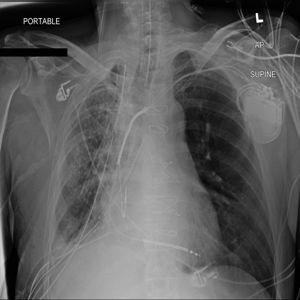

In [34]:
img.show()

In [62]:
dls = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=ColReader('Image Index', pref='sample/sample/images/'),
    get_y=ColReader('Finding Labels', label_delim='|'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(460, method='squish'),
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
).dataloaders(data)

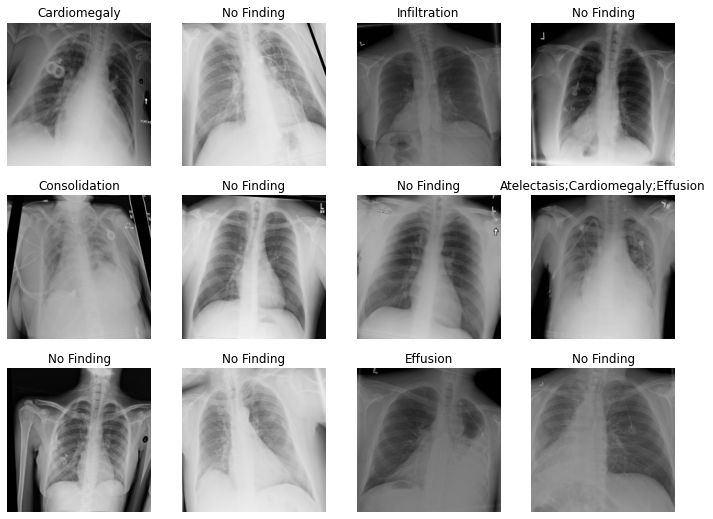

In [63]:
dls.show_batch(max_n=12)

In [64]:
loss_func = nn.BCEWithLogitsLoss()

In [65]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.8), loss_func=loss_func)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

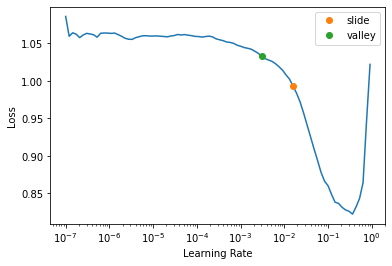

In [66]:
lr = learn.lr_find(suggest_funcs=(slide, valley))

In [67]:
base_lr = (lr.slide + lr.valley)/2
base_lr

0.009434442268684506

In [68]:
learn = learn.to_fp16()

In [69]:
learn.fine_tune(epochs=1, freeze_epochs=1, base_lr=base_lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.547010,0.232820,0.926256,02:24


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.220004,0.205816,0.922747,02:27


# Trying to improve the results
---



## Adding color

In [15]:
img = Image.open('sample/sample/images/00000013_005.png')

In [17]:
color_map = cm.jet
img = np.array(img)
img = color_map(img)

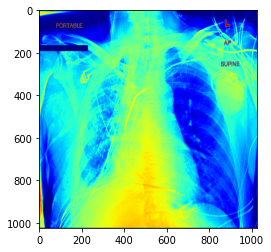

In [18]:
plt.imshow(img)
plt.show()

## Changing gamma

In [57]:
img = Image.open('sample/sample/images/00000013_005.png')

In [58]:
gamma = 0.5
img = exposure.adjust_gamma(np.array(img), gamma)

In [59]:
img = Image.fromarray(np.uint8(img * 255))

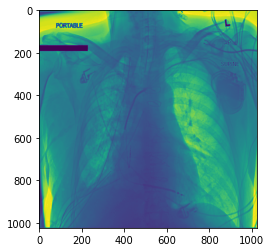

In [60]:
plt.imshow(img)
plt.show()

## Grad-CAM

In [ ]:
!pip install torchcam

In [79]:
import torch.nn as nn
import torchcam as CAM

class ResNet50WithCAM(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.cam = CAM(self.resnet.layer4)
        
        self.resnet.fc.register_forward_hook(self.cam.forward_hook)
        self.resnet.fc.register_backward_hook(self.cam.backward_hook)
        
    def forward(self, x):
        return self.resnet(x)

In [80]:
path = 'sample/sample/images/00000013_005.png'

In [81]:
from PIL import Image
from torchvision import transforms

# load the image
img = Image.open(path)

# define the transformations to apply to the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# apply the transformations to the image
img_tensor = transform(img)

# create an instance of the modified model
model = ResNet50WithCAM()

# put the model in evaluation mode
model.eval()

# compute the predicted class probabilities for the image
with torch.no_grad():
    outputs = model(img_tensor.unsqueeze(0))
    probs = nn.Softmax(dim=1)(outputs).squeeze(0)

# generate the Grad-CAM visualization for the top predicted class
target_class = torch.argmax(probs)
visualization = model.cam(input_tensor=img_tensor.unsqueeze(0), target_category=target_class)

# convert the visualization to a PIL image and save it
visualization = transforms.ToPILImage()(visualization[0])
#visualization.save(path)


RuntimeError: ignored